**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [1]:
! pip install aeon lightning torchmetrics torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 58.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [2]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# Prédiction de la concentration en benzène

Dans ce notebook, vous allez travailler sur le jeu de données [Benzene Concentration](https://zenodo.org/records/3902673).
Voici quelques informations supplémentaires sur le jeu de données :

> L'objectif de ce jeu de données est de prédire la concentration de benzène dans une ville italienne. Ce jeu de données contient 8 878 séries temporelles obtenues à partir de l'ensemble de données sur la qualité de l'air provenant du référentiel UCI. La série temporelle comporte 8 dimensions qui consistent en des réponses moyennes horaires provenant d'un ensemble de 5 capteurs chimiques à oxyde métallique intégrés dans un dispositif multicapteur chimique de qualité de l'air, ainsi que la température, l'humidité relative et l'humidité absolue. Le dispositif multicapteur chimique de qualité de l'air était situé sur le terrain dans une zone fortement polluée, au niveau de la route, dans une ville italienne. Les données ont été enregistrées de mars 2004 à février 2005 (un an), ce qui représente les enregistrements librement accessibles les plus longs des réponses des capteurs chimiques de qualité de l'air déployés sur le terrain. Les concentrations moyennes horaires de référence pour le CO, les hydrocarbures non méthaniques, le benzène, les oxydes d'azote totaux (NOx) et le dioxyde d'azote (NO2) ont été fournies par un analyseur certifié de référence situé au même endroit.

Le benzène est un composé organique appartenant à la famille des hydrocarbures aromatiques monocycliques.
Il est dangereux à de nombreux titres [...] : très inflammable, toxique, irritant, cancérogène et mutagène.
Les principales voies d'exposition de la population au benzène sont les vapeurs d'essence, les gaz d'échappement, les émanations industrielles, la fumée de cigarette ainsi que la combustion du bois (source : [Wikipedia](https://fr.wikipedia.org/wiki/Benzène)).

**L'objectif est de prédire la concentration en benzène à partir des séries temporelles.**

## Téléchargement et visualisation des données

La fonction `load_dataset()` définie ci-dessous permet de télécharger le jeu de données.

In [4]:
import numpy as np
import torch


def load_dataset(train, path="data"):
    """Charge le jeu de données.

    Parameters
    ----------
    train : bool
        Si True, renvoie le jeu d'entraînement. Sinon, renvoie le jeu de validation.

    path : str
        Chemin du répertoire où charger ou télécharger le jeu de données.

    Returns
    -------
    X : Tensor, shape = (n_observations, n_canaux, n_points)
        Entrées.

    y : Tensor, shape = (n_observations,)
        Sorties (labels).
    """
    from aeon.datasets import load_regression

    # Determine which split is (down)loaded
    split = "train" if train else "test"

    # (Down)load the dataset
    X, y = load_regression("BenzeneConcentration", split=split, extract_path=path)

    # Format y
    y = y.reshape(-1, 1)

    # Convert the arrays to tensors
    X = torch.from_numpy(X).to(dtype=torch.float32)
    y = torch.from_numpy(y).to(dtype=torch.float32)

    return X, y

Il suffit d'appeler cette fonction pour récupérer les jeux d'entraînement et de validation.

In [5]:
X_train, y_train = load_dataset(train=True)
X_val, y_val = load_dataset(train=False)

Pour chaque jeu de données, nous avons 2 variables Python :

* `X` contient les entrées (c'est-à-dire les séries temporelles) ; il s'agit d'un tenseur de taille `(n_observations, n_canaux, n_points)`.
* `y` contient les sorties (c'est-à-dire les concentrations en benzène) ; il s'agit d'un tenseur de taille `(n_observations,)`.


### Question 1

Déterminez le nombre d'enregistrements dans les jeux d'entraînement et de validation.
Déterminez (par du code) la taille de chaque observation (on admettra que toutes les observations ont la même taille, il suffit donc de calculer la taille d'une seule observation).

In [20]:
# TODO
print(f'Le nombre d\'enregistrements dans le jeu d\'entraînement est {len(X_train)}.')
print(f'Le nombre d\'enregistrements dans le jeu de validation est {len(X_val)}.')
print(f'La taille de chaque observation est {X_train[0].shape}')

Le nombre d'enregistrements dans le jeu d'entraînement est 3349.
Le nombre d'enregistrements dans le jeu de validation est 5163.
La taille de chaque observation est torch.Size([8, 240])


In [21]:
X_train[0]

tensor([[1.3600e+03, 1.2922e+03, 1.4020e+03,  ..., 1.3048e+03, 1.2825e+03,
         1.3922e+03],
        [1.0455e+03, 9.5475e+02, 9.3925e+02,  ..., 8.8400e+02, 8.4425e+02,
         9.6725e+02],
        [1.0562e+03, 1.1738e+03, 1.1400e+03,  ..., 9.8000e+02, 1.0355e+03,
         9.2975e+02],
        ...,
        [1.3600e+01, 1.3300e+01, 1.1900e+01,  ..., 1.9500e+01, 1.9500e+01,
         1.9050e+01],
        [4.8875e+01, 4.7700e+01, 5.3975e+01,  ..., 4.2250e+01, 4.2325e+01,
         4.3800e+01],
        [7.5775e-01, 7.2549e-01, 7.5024e-01,  ..., 9.4758e-01, 9.4926e-01,
         9.5557e-01]])

In [27]:
y_train[0]

tensor([9.7246])

In [12]:
X_train[0][0]

tensor([1360.0000, 1292.2500, 1402.0000, 1375.5000, 1272.2500, 1197.0000,
        1185.0000, 1136.2500, 1094.0000, 1009.7500, 1011.0000, 1066.0000,
        1051.7500, 1144.0000, 1333.2500, 1351.0000, 1233.2500, 1178.7500,
        1236.0000, 1285.5000, 1371.0000, 1310.0000, 1291.7500, 1383.0000,
        1580.7500, 1775.5000, 1640.0000, 1312.7500,  964.5000,  912.7500,
        1080.2500, 1043.7500,  987.7500,  888.7500,  831.0000,  847.2500,
         927.0000, 1090.5000, 1587.0000, 1544.5000, 1350.2500, 1262.7500,
        1206.2500, 1251.5000, 1287.0000, 1352.7500, 1309.0000, 1274.0000,
        1509.5000, 1525.2500, 1843.0000, 1597.7500, 1483.5000, 1677.2500,
        1279.5000, 1196.2500, 1183.7500, 1171.7500, 1147.0000,  978.2500,
        1099.5000, 1112.2500, 1335.5000, 1408.3334, 1447.0000, 1541.5000,
        1451.2500, 1328.2500, 1206.5000, 1239.5000, 1306.0000, 1326.0000,
        1472.7500, 1609.0000, 1610.7500, 1620.5000, 1444.2500, 1418.0000,
        1533.5000, 1483.5000, 1366.750

La fonction `plot_sample()` définie ci-dessous permet d'afficher une observation.

In [23]:
import matplotlib.pyplot as plt


def plot_sample(X, y, idx):
    """Affiche une observation d'un jeu de données.

    Parameters
    ----------
    X : array, shape = (n_observations, n_canaux, n_points)
        Entrées.

    y : array, shape = (n_observations,)
        Sorties (labels).

    idx : int
        Indice de l'observation à afficher.
    """
    if not (isinstance(idx, int) and (0 <= idx < len(X))):
        raise ValueError("L'indice n'est pas valide.")

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    labels = [
        "Monoxyde de carbone",
        "Hydrocarbures non méthaniques",
        "Oxydes d'azote",
        "Dioxyde d'azote",
        "Ozone",
    ]
    for label, i in zip(labels, range(5)):
        plt.plot(X[idx, i], color=f"C{i}", label=label)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))

    plt.subplot(1, 3, 2)
    labels = ["Température", "Humidité relative"]
    for label, i in zip(labels, range(5, 7)):
        plt.plot(X[idx, i], color=f"C{i}", label=label)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))

    plt.subplot(1, 3, 3)
    label = "Humidité absolue"
    i = 7
    plt.plot(X[idx, i], color=f"C{i}", label=label)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15))

    _ = plt.suptitle(f"Concentration en benzène = {y[idx].item():.4f}")

### Question 2

Appelez la fonction `plot_sample()` pour visualiser quelques observations des jeux d'entraînement et de validation.

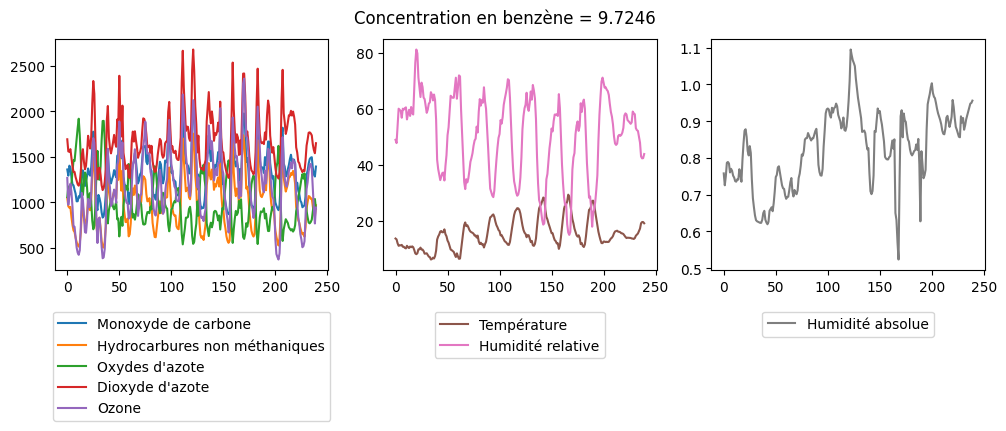

In [24]:
# TODO
plot_sample(X_train, y_train, 0)

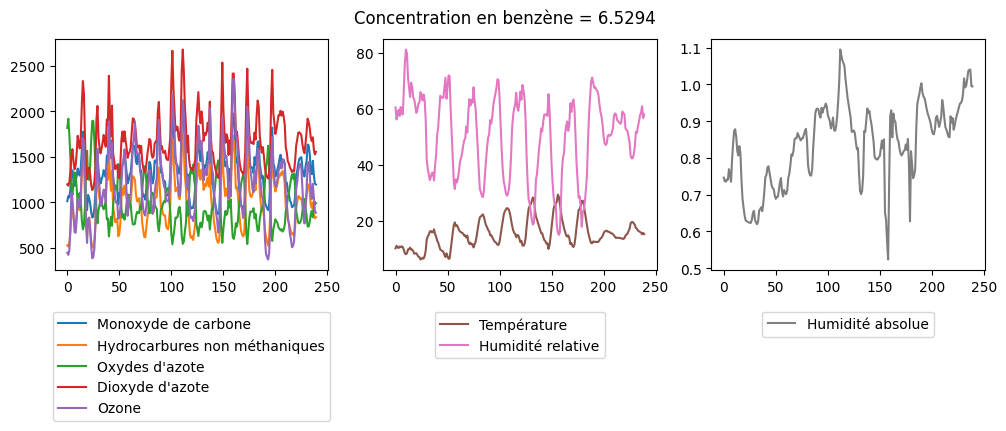

In [25]:
# TODO
plot_sample(X_train, y_train, 10)

### Question 3

Affichez la distribution des concentrations en benzène sur les jeux d'entraînement et de validation. Vous pouvez utiliser la fonction [`matplotlib.pyplot.hist()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

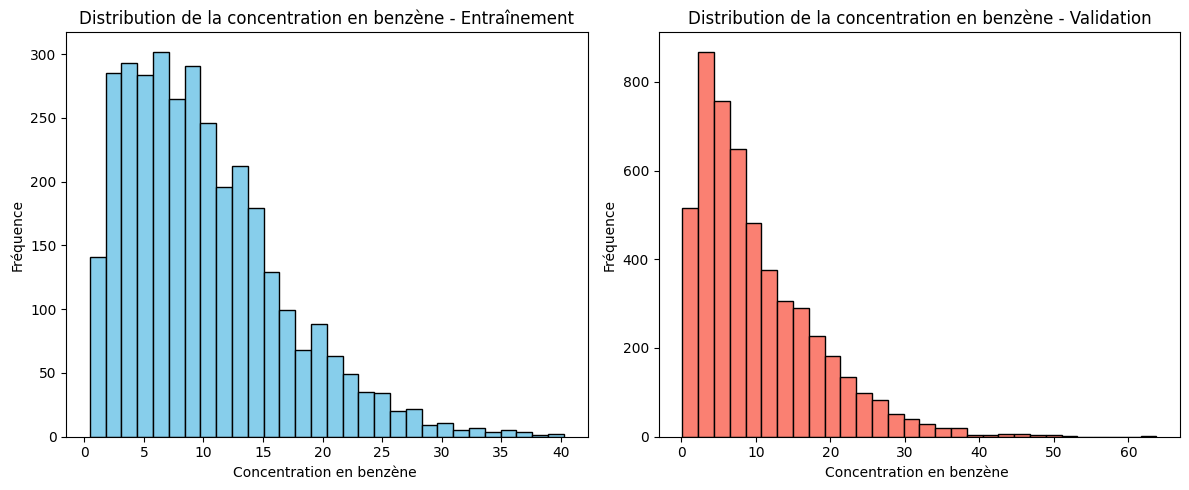

In [29]:
# TODO
import matplotlib.pyplot as plt

# Créer une figure avec deux histogrammes côte à côte
plt.figure(figsize=(12, 5))

# Histogramme pour le jeu d'entraînement
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution de la concentration en benzène - Entraînement")
plt.xlabel("Concentration en benzène ")
plt.ylabel("Fréquence")

# Histogramme pour le jeu de validation
plt.subplot(1, 2, 2)
plt.hist(y_val, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution de la concentration en benzène - Validation")
plt.xlabel("Concentration en benzène ")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


Nous allons évaluer la performance des modèles avec la racine de l’erreur quadratique moyenne (*root mean squared error*) :
$$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2}
$$

Un modèle trivial consiste à prédire une constante, quelle que soit les données en entrée.
Pour la racine de l’erreur quadratique moyenne, la meilleure constante possible est la moyenne :
$$
    \forall j \in \{1, \ldots, n\}, \; \hat{y}_j = \frac{1}{n} \sum_{i=1}^n y_i
$$

### Question 4

Calculez les racines des erreurs quadratiques moyennes sur les jeux d'entraînement et de validation. Cela vous fournira une valeur de référence pour évaluer les futurs modèles entraînés.

In [37]:
# TODO
import numpy as np
from sklearn.metrics import mean_squared_error

# Créer un vecteur de la même taille que y_train, rempli avec la moyenne de y_train
y_train_mean = np.full_like(y_train, fill_value=y_train.mean(), dtype=np.float32)

# Calculer la racine de l'erreur quadratique moyenne sur le jeu d'entraînement
rmse_train = mean_squared_error(y_train, y_train_mean) ** 0.5
print(f"La racine de l'erreur quadratique moyenne sur le jeu d'entraînement d' un modèle qui prédit la moyenne en tout point est {rmse_train:.4f}")

La racine de l'erreur quadratique moyenne sur le jeu d'entraînement d' un modèle qui prédit la moyenne en tout point est 6.5724


### Question 5

Créez les *dataloaders* pour les jeux d'entraînement et de validation en utilisant la classe [`torch.utils.data.DataLoader()`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) avec des lots de taille $16$. N'oubliez pas de mélanger (suffle) les observations pour le jeu d'entraînement, mais pas pour le jeu de validation. Pour créer les jeux de données, utiliser la classe [`torch.utils.data.TensorDataset()`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [38]:
# TODO
from torch.utils.data import DataLoader

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_val = torch.utils.data.TensorDataset(X_val, y_val)


dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=16)


## Classe de base pour la régression

Vous allez entraîner plusieurs modèles avec des architectures différentes.
Néanmoins, plusieurs opérations seront identiques pour tous ces modèles.
C'est pourquoi nous allons tout d'abord définir une classe de base avec toutes les opérations identiques.
La classe `BaseClass()` définie ci-dessous va contenir ces opérations communes.

### Question 6

Complétez le code manquant dans les méthodes `__init__()`, `step()` et `configure_optimizers()` de la classe `BaseClass()` avec les informations suivantes :
* `__init__()` : il faut définir la fonction de perte (`self.loss`) et les métriques pour les jeux d'entraînement (`self.metric_train`) et d'évaluation (`self.metric_val`) ; on utilisera l'erreur quadratique moyenne comme fonction de perte et la racine de l'erreur quadratique moyenne comme métrique d'évaluation.
* `step()` : étant donné un lot d'observations (`batch`), il faut :
    + récupérer les entrées (`X`) et les sorties (`y`),
    + calculer la valeur prédite pour chacune des entrées du lot (`y_pred`),
    + calculer la fonction de coût entre les valeurs prédites et les vraies valeurs (`loss`).
* `configure_optimizers()` : on utilisera l'algorithme d'optimisation *Adam* avec un taux d'apprentissage de $10^{-4}$.

Voici les liens vers les documentations des classes pertinentes :
[`torch.nn.MSELoss()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html),
[`torchmetrics.MeanSquaredError()`](https://lightning.ai/docs/torchmetrics/stable/regression/mean_squared_error.html) et
[`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [45]:
import lightning as L
from torchmetrics import MeanSquaredError


class BaseClass(L.LightningModule):

    def __init__(self):
        """Constructeur.

        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        ### BEGIN TODO ###
        # Initialisation de la fonction de perte
        self.loss = torch.nn.MSELoss()

        # Initialisation des métriques
        self.metric_train = MeanSquaredError(squared=False)
        self.metric_val = MeanSquaredError(squared=False)
        #### END TODO ####

    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        ### BEGIN TODO ###
        X, y = batch
        y_pred = self(X)
        loss = self.loss(y, y_pred)
        #### END TODO ###

        if dataset == "training":
            metric = self.metric_train
            name = "train"
            bar_step = True
        else:
            metric = self.metric_val
            name = "val"
            bar_step = False

        metric_score = metric(y_pred, y) # Évaluation de la métrique
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"metric_{name}", metric_score, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -------------------------------------------------
            |     Jeu      | Fonction de perte |    RMSE    |
            | ------------ | ----------------- | ---------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['metric_train'].item():^12.4f}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['metric_val'].item():^12.4f}|
            -------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, '\n')

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        ### BEGIN TODO ###
        optimizer = torch.optim.Adam(self.parameters())
        #### END TODO ####
        return optimizer

## Régression par perceptron multicouche

Comme la longueur de chacun des signaux est fixe après prétraitement des données, il est possible d'utiliser un perceptron multicouche.

Vous allez implémenter un perceptron multicouche dans la classe `MLP()` définie ci-dessous avec l'architecture séquentielle suivante :

* Aplatissement de l'observation pour la transformer en un tenseur à une dimension (un vecteur)
* Couche linéaire avec 256 variables en sortie
* Fonction d'action ReLU
* Couche de désaction (*dropout*) avec une probabilité de $0.2$
* Couche linéaire avec 64 variables en sortie
* Fonction d'action ReLU
* Couche linéaire avec 1 variable en sortie

Voici les liens vers les documentations des classes pertinentes :
[`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html),
[`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html),
[`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) et
[`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

### Question 7

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `MLP()`.
Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [46]:
class MLP(BaseClass):

    def __init__(self):
        super().__init__()

        ### BEGIN TODO ###
        self.sequential = torch.nn.Sequential(torch.nn.Flatten(),
              torch.nn.Linear(1920, 256),
              torch.nn.ReLU(),
              torch.nn.Dropout(0.2),
              torch.nn.Linear(256, 64),
              torch.nn.ReLU(),
              torch.nn.Linear(64, 1))
        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        y_pred = self.sequential(x)
        #### END TODO ####
        return y_pred

In [ ]:
# TODO

### Question 8

Entraînez votre modèle pendant $10$ époques.

In [47]:
# TODO
model1  = MLP()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model1, dataloader_train, dataloader_val)


INFO: 
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | MSELoss          | 0      | train
1 | metric_train | MeanSquaredError | 0      | train
2 | metric_val   | MeanSquaredError | 0      | train
3 | sequential   | Sequential       | 508 K  | train
----------------------------------------------------------
508 K     Trainable params
0         Non-trainable params
508 K     Total params
2.033     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Version 2



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 1 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |    12619.98730    |  40.9914   |
|  Validation  |     439.41409     |  20.1425   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 2 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     183.73996     |  12.8454   |
|  Validation  |     63.51912      |   7.0754   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 3 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     102.06945     |   9.7341   |
|  Validation  |     90.57376      |   8.0907   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 4 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     79.15289      |   8.6466   |
|  Validation  |     60.37133      |   7.3087   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 5 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     64.16064      |   7.8169   |
|  Validation  |     66.85875      |   7.0214   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 6 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     54.80882      |   7.2153   |
|  Validation  |     57.49778      |   6.4685   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 7 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     47.50368      |   6.6451   |
|  Validation  |     69.42451      |   7.1437   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 8 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     34.96151      |   5.7408   |
|  Validation  |     36.68208      |   5.1854   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 9 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     26.90570      |   5.0382   |
|  Validation  |     34.54007      |   5.0275   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 10 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     23.99021      |   4.7487   |
|  Validation  |     26.78976      |   4.6662   |
------------------------------------------------- 



## Régression par réseau de neurones convolutif

Comme la longueur de chacun des signaux est fixe après prétraitement des données et que les données sont séquentielles, il est également possible et pertinent d'utiliser un réseau de neurones convolutif.

Vous allez implémenter un réseau de neurones convolutif dans la classe `CNN()` définie ci-dessous avec l'architecture séquentielle suivante :

* Couche de convolution unidimensionnelle avec $16$ canaux en sortie, un noyau de taille $7$ et du rembourrage de telle sorte que la sortie ait la même taille que l'entrée
* Fonction d'action ReLU
* Couche de regroupement unidimensionnelle avec un noyau et un pas de taille $2$
* Couche de convolution unidimensionnelle avec $32$ canaux en sortie, un noyau de taille $5$ et du rembourrage de telle sorte que la sortie ait la même taille que l'entrée
* Fonction d'action ReLU
* Couche de regroupement unidimensionnelle avec un noyau et un pas de taille $2$
* Couche de convolution unidimensionnelle avec $64$ canaux en sortie, un noyau de taille $3$ et du rembourrage de telle sorte que la sortie ait la même taille que l'entrée
* Fonction d'action ReLU
* Couche de regroupement unidimensionnelle avec un noyau et un pas de taille $2$
* Aplatissement de l'entrée (en deux dimensions) pour la transformer en un tenseur à une dimension (un vecteur)
* Couche linéaire avec $1920$ variables en entrée et $256$ variables en sortie
* Fonction d'action ReLU
* Couche linéaire avec $1$ variable en sortie

Voici les liens vers les documentations des classes pertinentes :
[`torch.nn.Conv1d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html),
[`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html),
[`torch.nn.MaxPool1d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html),
[`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) et
[`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

### Question 9

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `CNN()`.
Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [48]:
class CNN(BaseClass):

    def __init__(self):
        super().__init__()

        ### BEGIN TODO ###
        self.sequential = torch.nn.Sequential( torch.nn.Conv1d(in_channels=8, out_channels=16, kernel_size=7, padding='same'),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding='same'),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=2, stride=2),
        torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(1920, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 1))
        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        y_pred = self.sequential(x)
        #### END TODO ####
        return y_pred

In [ ]:
# TODO

### Question 10

Entraînez votre modèle pendant $10$ époques.

In [51]:
# TODO

model2  = CNN()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model2, dataloader_train, dataloader_val)

INFO: 
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | MSELoss          | 0      | train
1 | metric_train | MeanSquaredError | 0      | train
2 | metric_val   | MeanSquaredError | 0      | train
3 | sequential   | Sequential       | 501 K  | train
----------------------------------------------------------
501 K     Trainable params
0         Non-trainable params
501 K     Total params
2.007     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Version 4



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 1 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     143.58678     |   4.1730   |
|  Validation  |     11.89192      |   3.0933   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 2 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      1.72191      |   1.2448   |
|  Validation  |      7.17423      |   2.3871   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 3 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.99371      |   0.9419   |
|  Validation  |      7.09302      |   2.3702   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 4 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.92266      |   0.9046   |
|  Validation  |      5.77878      |   2.1280   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 5 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.55793      |   0.7091   |
|  Validation  |      7.14912      |   2.4364   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 6 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.55199      |   0.7069   |
|  Validation  |      5.73844      |   2.1306   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 7 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.42200      |   0.6234   |
|  Validation  |      4.98620      |   1.9821   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 8 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.38905      |   0.5941   |
|  Validation  |      4.53087      |   1.8742   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 9 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.32852      |   0.5455   |
|  Validation  |      5.32751      |   2.0235   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 10 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      0.28147      |   0.5121   |
|  Validation  |      5.42817      |   2.0885   |
------------------------------------------------- 



## Régression par réseau de neurones récurrent

Comme les données sont séquentielles, il est également possible et pertinent d'utiliser un réseau de neurones récurrent.

Vous allez implémenter un réseau de neurones récurrent dans la classe `RNN()` définie ci-dessous avec l'architecture séquentielle suivante :

* Couche récurrente de type LSTM (unidirectionnelle) avec $256$ variables pour chaque état caché
* Couche linéaire avec 1 variable en sortie

Voici les liens vers les documentations des classes pertinentes :
[`torch.nn.LSTM()`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) et
[`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

### Question 11

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `RNN()`.
Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [58]:
class RNN(BaseClass):

    def __init__(self):
        super().__init__()

        ### BEGIN TODO ##

        self.lstm = torch.nn.LSTM(
            input_size=8,       # chaque pas de temps contient 8 capteurs
            hidden_size=256,    # dimension de l’état caché
            num_layers=1,       # une seule couche LSTM
            batch_first=True    # pour avoir (batch, seq, features)
        )
        self.fc = torch.nn.Linear(256, 1)

        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        x = x.permute(0, 2, 1)  # on inverse pour avoir time steps = 240
        out, (h_n, c_n) = self.lstm(x)
        # on garde le dernier état caché (correspondant à la dernière observation temporelle)
        y_pred = self.fc(h_n[-1])
        #### END TODO ####
        return y_pred

In [ ]:
# TODO

### Question 12

Entraînez votre modèle pendant $10$ époques.

In [59]:
# TODO
model3  = RNN()
trainer = L.Trainer(max_epochs=10)
trainer.fit(model3, dataloader_train, dataloader_val)

INFO: 
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | MSELoss          | 0      | train
1 | metric_train | MeanSquaredError | 0      | train
2 | metric_val   | MeanSquaredError | 0      | train
3 | lstm         | LSTM             | 272 K  | train
4 | fc           | Linear           | 257    | train
----------------------------------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.091     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Version 8



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 1 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     45.65103      |   6.3112   |
|  Validation  |     37.91104      |   5.3185   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 2 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |     15.41268      |   3.6657   |
|  Validation  |     25.18073      |   4.3359   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 3 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      9.46279      |   2.8333   |
|  Validation  |     21.18370      |   3.9411   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 4 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      7.56753      |   2.5137   |
|  Validation  |     19.91488      |   3.8798   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 5 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      6.45344      |   2.3293   |
|  Validation  |     16.59043      |   3.4541   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 6 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      6.24435      |   2.2815   |
|  Validation  |     17.26999      |   3.6288   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 7 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      5.74473      |   2.1931   |
|  Validation  |     15.57458      |   3.3828   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 8 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      5.42899      |   2.1416   |
|  Validation  |     13.25178      |   3.0377   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 9 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      4.67967      |   1.9908   |
|  Validation  |     15.76855      |   3.5044   |
------------------------------------------------- 



Validation: |          | 0/? [00:00<?, ?it/s]

Époque 10 / 10
-------------------------------------------------
|     Jeu      | Fonction de perte |    RMSE    |
| ------------ | ----------------- | ---------- |
| Entraînement |      4.05271      |   1.8407   |
|  Validation  |     11.91074      |   3.0020   |
------------------------------------------------- 



### Question 13

Finalement, lequel de vos trois modèles est le meilleur ? Faîtes-vous mieux que le modèle trivial ? Justifiez votre réponse.

Le modèle trivial (RMSE = 6.5724) sert de référence simple.
Les trois modèles testés font mieux que ce dernier, ce qui montre qu’ils apprennent effectivement la relation entre les signaux des capteurs et la concentration en benzène.
Parmi eux, le CNN donne les meilleurs résultats avec un RMSE de 2.08 sur le jeu de validation, contre 3.00 pour le RNN et 4.66 pour le MLP.
Il s’agit donc du modèle le plus performant, capable de bien généraliser sans surapprentissage marqué. Le LSTM apprend bien la dynamique temporelle globale, mais peut être plus difficile à optimiser (plus de paramètres, risque de sur/apprentissage partiel).
